# 逻辑斯蒂回归

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 读取数据并处理
lines = np.loadtxt('data/lr_dataset.csv',delimiter=',',dtype=float)
x_total = lines[:,0:2]
y_total = lines[:,2]
print('数据集大小：',len(x_total))

数据集大小： 1000


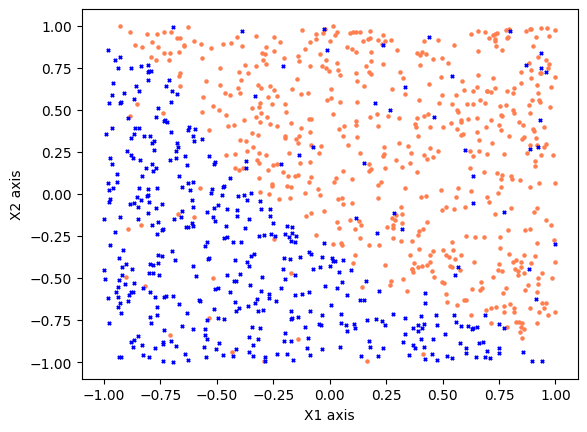

In [23]:
# 数据可视化
pos_index = np.where(y_total == 1)
neg_index = np.where(y_total == 0)
plt.scatter(x_total[pos_index,0], x_total[pos_index, 1],marker='o',color='coral',s=5)
plt.scatter(x_total[neg_index,0], x_total[neg_index, 1],marker='x',color='blue',s=5)
plt.xlabel('X1 axis')
plt.ylabel('X2 axis')
plt.show()

In [24]:
# 划分测试集与训练集
np.random.seed(2023)
ratio = 0.7
split = int(len(x_total) * ratio)
idx = np.random.permutation(len(x_total))
x_total = x_total[idx]
y_total = y_total[idx]
x_train,y_train = x_total[:split],y_total[:split]
x_test,y_test = x_total[split:],y_total[split:]

In [25]:
# 评价指标的实现
# ACC
def acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

# AUC
def auc(y_true, y_pred):
    # 按预测值从大到小排列，排序越靠前的正类概率越大、
    idx = np.argsort(y_pred[::-1])
    y_true = y_true[idx]
    y_pred = y_pred[idx]
    # 把y_pred中不重复的值当作阈值，依次计算FP样本和TP样本的数量
    # 由于两个数组已经排序且位置对应，直接从前向后累加即可
    tp = np.cumsum(y_true)
    fp = np.cumsum(1 - y_true)
    tpr = tp / tp[-1]
    fpr = fp / fp[-1]
    # 依次枚举FPR，计算曲线下的面积
    # 方便起见，给FPR和TPR最开始添加（０，０）
    s = 0.0
    tpr = np.concatenate([[0],tpr])
    fpr = np.concatenate([[0],fpr])
    for i in range(1,len(fpr)):
        s += (fpr[i] - fpr[i - 1]) * tpr[i]
    return s

In [2]:
# 逻辑斯蒂函数
def logistic(z):
    return 1 / (1 + np.exp(-z))

def GD(num_steps,learning_rate,l2_coef):
    # 初始化参数模型
    theta = np.random.normal(size=(X.shape[1],))
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    train_auc = []
    test_auc = []
    for i in range(num_steps):
        pred = logistic(X @ theta)
        grad = -X.T @ (y_train - pred) + l2_coef * theta
        theta -= learning_rate * grad
        # 记录损失函数
        train_loss =(- y_train.T @ np.log(pred) 
                     - (1 - y_train).T @ np.log(1 - pred) 
                     + l2_coef * np.linalg.norm(theta) ** 2 / 2)
        train_losses.append(train_loss / len(X))
        test_pred = logistic(X_test @ theta)
        test_loss = (- y_test.T @ np.log(test_pred) \
                     - (1 - y_test).T @ np.log(1 - test_pred))
        test_losses.append(test_loss / len(X_test))
        # 记录每个评价指标，阈值采用0.5
        train_acc.append(acc(y_train, pred >= 0.5))
        test_acc.append(acc(y_test, test_pred >= 0.5))
        train_auc.append(auc(y_train,pred))
        test_auc.append(auc(y_test, test_pred))
    return theta, train_losses, test_losses, train_acc, test_acc, train_auc, test_auc


In [ ]:
# 设置参数
num_steps = 250
learning_rate = 0.002
l2_coef = 1.0
np.random(2023)


# Other
### np.mean()
- 计算数组的平均值
- https://blog.csdn.net/m0_51581537/article/details/129392019